# Bubble and Dew Point Calculations for Binary Mixtures

by Jeffrey Kantor  (jeff at nd.edu). The latest version of this notebook is available at [https://github.com/jckantor/CBE20255](https://github.com/jckantor/CBE20255). 

### Summary

This [Jupyter notebook](http://jupyter.org/notebook.html) illustrates the use of Raoult's Law and Antoine's equation to compute the bubble and dew points for an ideal solution. The video is used with permission from [learnCheme.com](http://learncheme.ning.com/), a project at the University of Colorado funded by the National Science Foundation and the Shell Corporation.

## Overview of the Calculations

<img src = "https://raw.githubusercontent.com/jckantor/CBE20255/master/images/BubbleDewPointCalculations.png" align="center" width="600">

## Bubble Point Calculations for Binary Mixtures

For an ideal binary mixture of components $A$ and $B$, from Raoult's law the bubble point temperature must satisfy

$$P = x_A P_A^{sat}(T) + x_B P_B^{sat}(T)$$

where $x_A P_A^{sat}(P)$ and $x_B P_B^{sat}(P)$ are the partial pressures of $A$ and $B$, respectively. This relationship is the basis for an interative procedure for computing the bubble point temperature.

Step 1: Guess the temperature.

Step 2: Compute the  'K-factors'

$$K_A = \frac{P^{sat}_A(T)}{P}\qquad\mbox{and}\qquad K_B = \frac{P^{sat}_B(T)}{P}$$

Step 3: Compute the vapor phase mole fractions 

$$y_A = K_A x_A\qquad\mbox{and}\qquad y_B = K_B x_B$$

Step 4: Check if $y_A + y_B = 1$. Adjust the temperature and repeat until the vapor phase mole fractions sum to one.

The procedure is demonstrated in the following video.

### Solution by Manual Iteration

We're given a binary mixture composed of acetone and ethanol at atmospheric pressure where the liquid phase mole fraction of acetone is 0.40. The problem is to find the equilibrium temperature and the composition of the vapor phase.

Initialize the Python workspace with with default settings for plots.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
A = 'acetone'
B = 'ethanol'

P = 760
xa = 0.4
xb = 1 - xa

We will use Antoine's equation to compute the saturation pressures for the pure components. These function are stored as entries in a simple Python dictionary.

In [3]:
# Antoine's equations. T [deg C], P [mmHg]

Psat = dict()
Psat['acetone'] = lambda T: 10**(7.02447 - 1161.0/(224 + T))
Psat['ethanol'] = lambda T: 10**(8.04494 - 1554.3/(222.65 + T))

The next cell performs the calculations outlined in the video above. Execute this cell with different values of `T` until the vapor phase mole fractions sum to one.

In [4]:
T = 65

Ka = Psat[A](T)/P
Kb = Psat[B](T)/P

ya = Ka*xa
yb = Kb*xb

print(ya + yb)

0.880884611444


### Solution with a Root-Finding Function

To compute the bubble point for a binary mixture we need to solve the equation

$$P = x_A P^{sat}_A(T_{bubble}) + x_B P^{sat}_B(T_{bubble})$$

where $P$ and $x_A$ (and therefore $x_B = 1 - x_A$) are known. The bubble point composition is given by

$$y_A = \frac{x_A P^{sat}_A(T)}{P}\qquad\mbox{and}\qquad y_B = \frac{x_B P^{sat}_B(T)}{P}$$

Matlab and Python functions for solving equations rely on *root-finding* methods, that is, methods that find the *zeros* of a function. In this case we need to write our problem as

$$x_A \frac{P^{sat}_A(T)}{P} + x_B\frac{P^{sat}_B(T)}{P} = 1$$

Here we use the `brentq` function from the scipy.optimize library to return the root of this equation.

In [5]:
from scipy.optimize import brentq

brentq(lambda T: xa*Psat[A](T)/P + xb*Psat[B](T)/P - 1.0 ,0,100)

68.5195836108029

In [6]:
def Tbub(X) :
    xa,xb = X
    return brentq(lambda T: xa*Psat[A](T)/P + xb*Psat[B](T)/P - 1.0 ,0,100)

print("Bubble point temperature = {:6.3f} [deg C]".format(Tbub((xa,xb))))

ya = xa*Psat[A](Tbub((xa,xb)))/P
yb = xb*Psat[B](Tbub((xa,xb)))/P

print("Bubble point composition = {:.3f}, {:.3f}".format(ya,yb))

Bubble point temperature = 68.520 [deg C]
Bubble point composition = 0.598, 0.402


### Bubble Point Curve for a Txy Diagram

It's a relatively simply matter to encapsulate the bubble point calculation into a function that, given the liquid phase mole fraction for an ideal binary mixture, uses a root-finding procedure to return the bubble point temperature.

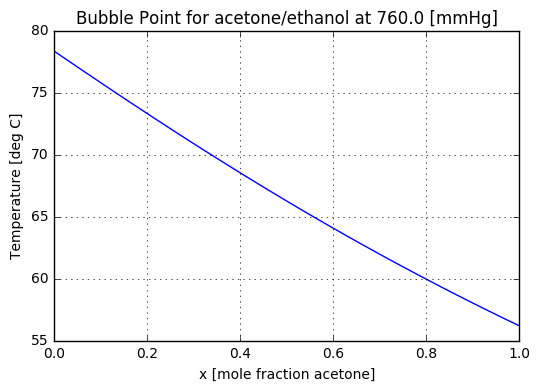

In [7]:
x = np.linspace(0,1)
plt.plot(x,[Tbub((xa,xb)) for (xa,xb) in zip(x,1-x)])
plt.xlabel('x [mole fraction {:s}]'.format(A))
plt.ylabel('Temperature [deg C]')
plt.title('Bubble Point for {:s}/{:s} at {:5.1f} [mmHg]'.format(A,B,P))
plt.grid();

## Dew Point Calculations for a Binary Mixture

To compute the dew point for a binary mixture we need to solve the equation

$$y_A\frac{P}{P^{sat}_A(T)} + y_B\frac{P}{P^{sat}_B(T)} = 1$$

where $P$ and $y_A$ (and therefore $y_B = 1 - y_A$) are known. The dew point composition is given by

$$x_A = y_A\frac{P}{P^{sat}_A(T)}\qquad\mbox{and}\qquad x_B = y_B\frac{P}{P^{sat}_B(T)}$$

Matlab and Python functions for solving equations rely on *root-finding* methods, that is, methods that find the *zeros* of a function. Here we use the `fsolve` function from the scipy.optimize library to return the root of the dew point equation. Note that `fsolve` returns a list of roots, so the terminal `[0]` on the expression selects the first root (and presumably only) of the bubble point equation.

In [8]:
def Tdew(Y):
    ya,yb = Y
    return brentq(lambda T:ya*P/Psat[A](T) + yb*P/Psat[B](T) - 1.0,0,100)

print("Dew point temperature = {:6.3f} [deg C]".format(Tdew((ya,yb))))

xa = ya*P/Psat[A](Tdew((ya,yb)))
xb = yb*P/Psat[B](Tdew((ya,yb)))

print("Dew point composition = {:.3f}, {:.3f}".format(xa,xb))

Dew point temperature = 68.520 [deg C]
Dew point composition = 0.400, 0.600


### Dew Point Curve on the Txy diagram

As shown above for bubble point calculations, the dew point curve on the Txy diagram can be plotted by mapping the Tdew function onto a grid of mole fractions.

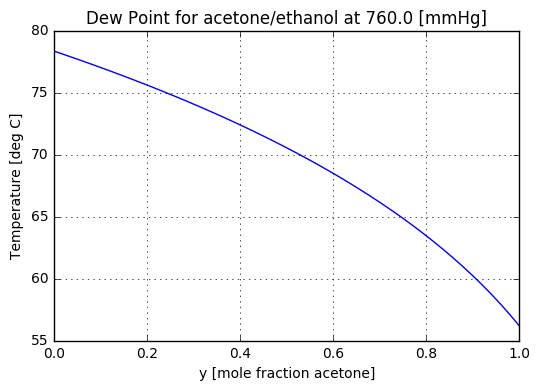

In [9]:
y = np.linspace(0,1)
plt.plot(y,[Tdew((ya,yb)) for (ya,yb) in zip(y,1-y)])
plt.xlabel('y [mole fraction {:s}]'.format(A))
plt.ylabel('Temperature [deg C]')
plt.title('Dew Point for {:s}/{:s} at {:5.1f} [mmHg]'.format(A,B,P))
plt.grid();